# Phylogeny of 13 ray-finned fish based on gene order data

The present notebook documents the code and procedure we used to establish the **gene-order-based phylogeny of ray-finned fish** presented in the **[the bowfin genome paper](https://www.researchsquare.com/article/rs-92055/v1)**. This phylogeny supports the **Holostei hypothesis** of ray-finned fish evolution, which defines **the bowfin and spotted gar as sister groups**. The notebook is a mixed language jupyter notebook including both **python and R** code. The code presented is aimed at this specifc analysis and should not be taken as optimized nor directly generalizable.

# Table of contents

- [Libraries and packages](#libraries-and-packages)
    - [External dependencies](#external-dependencies)
    - [Custom python modules](#custom-python-modules)
- [Input data description](#input-data-description)
- [Neighbor-joining gene order phylogeny](#gene-order-phylogeny)
    - [Marker genes selection](#marker-genes-selection)
    - [Adjacencies extraction](#adjacencies-extraction)
    - [Distance matrix computation](#distance-matrix-computation)
    - [Neighbor-joining tree reconstruction](#neighbor-joining-tree-reconstruction)
    - [Bootstrap support](#bootstrap-support)
- [Maximum parsimony gene order phylogeny](#gene-order-phylogeny-pars)


## Libraries and packages <a name="libraries-and-packages"></a>

All external dependencies to run the notebook are listed in the `binder/environment.yml` file, which includes both python packages and R libraries. Custom python modules are also stored in the `modules/` folder.

### External dependencies <a name="external-dependencies"></a>

In [3]:
#Standard imports
import os
import itertools
import glob
import bz2
from collections import defaultdict
import random
random.seed(1234)

In [4]:
#Gene tree manipulation
from Bio import Phylo
from Bio.Phylo.Consensus import majority_consensus,get_support
from ete3 import Tree, NodeStyle, TreeStyle,TextFace, AttrFace,faces

In [5]:
#Data loading and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")

In [6]:
#Use R in python
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Custom python modules <a name="custom-python-modules"></a>

In [98]:
#Load my python code
%run modules/genomes.py
%run modules/adjacencies.py
%run modules/matrix.py
%run modules/bootstrap.py
%run modules/plot_trees.py

## Input data description  <a name="input-data-description"></a>

All input data are stored in `data/gene_order_phylogeny/`.

In [8]:
! tree data/gene_order_phylogeny/

then: then/endif not found.
data/gene_order_phylogeny/
├── ancGenes.Euteleostomi.list.bz2
├── genes.Amia.calva.list.bz2
├── genes.Astyanax.mexicanus.list.bz2
├── genes.Danio.rerio.list.bz2
├── genes.Gallus.gallus.list.bz2
├── genes.Gasterosteus.aculeatus.list.bz2
├── genes.Lepisosteus.oculatus.list.bz2
├── genes.Oreochromis.niloticus.list.bz2
├── genes.Oryzias.latipes.list.bz2
├── genes.Paramormyrops.kingsleyae.list.bz2
├── genes.Poecilia.formosa.list.bz2
├── genes.Scleropages.formosus.list.bz2
├── genes.Takifugu.rubripes.list.bz2
├── genes.Tetraodon.nigroviridis.list.bz2
├── genes.Xenopus.tropicalis.list.bz2
└── genes.Xiphophorus.maculatus.list.bz2

0 directories, 16 files


It includes an `ancGenes` file defining **gene families** and files with **gene coordinates**, both in **dyogen format** (see PhylDiag). Briefly, gene families were defined from gene trees built with the TreeBeST pipeline, including a total of y genomes and x ray-finned fish (*internally designated as GoodThreshold Genomicus V2 data*). In what follows, a subset of this gene families, containing the **13 selected ray-finned fish** and **2 outgroups** (chicken and xenopus) is extracted and kept for all analysis.

In [9]:
GENES = f"data/gene_order_phylogeny/genes.%s.list.bz2"
FAMILIES = "data/gene_order_phylogeny/ancGenes.Euteleostomi.list.bz2"

## Neighbor-Joining gene order phylogeny <a name="gene-order-phylogeny"></a>

The gene order phylogeny is built in 5 steps detailed below. First, a **selection of marker genes** is conducted to limit the effect of differential gene content. Genomes are then reduced to this marker genes and **gene adjacencies** are stored. Next, a **distance matrix** and a **neighbor-joining tree** are built. Finally, **bootstrap** is perfomed to add support to nodes of the phylogeny.

*Note: the code below writes a lot of intermediary files that may seem unnecessary. These were initally used for additional unpublished controls and analyses.*

All outputs are stored in `output`.

In [10]:
! mkdir output

then: then/endif not found.
mkdir: impossible de créer le répertoire «output»: Le fichier existe


### Marker genes selection <a name="marker-genes-selection"></a>

Because the selected species contain teleost species that underwent a common whole-genome duplication event, we retained only gene families with exactly one gene copy in non-duplicated genomes and one or two gene copies in duplicated genomes.

In [11]:
# global variable with all species name
ALL_SPECIES = ['Gallus gallus','Xenopus tropicalis','Lepisosteus oculatus', 'Amia calva', 'Paramormyrops kingsleyae','Scleropages formosus', 'Astyanax mexicanus','Danio rerio','Gasterosteus aculeatus', 'Tetraodon nigroviridis', 'Takifugu rubripes', 'Oreochromis niloticus', 'Oryzias latipes', 'Poecilia formosa', 'Xiphophorus maculatus']

#global variable with latin to common name correspondance
SP_DICT = {'Gallus':'Chicken', 'Xenopus':'Xenopus', 'Lepisosteus':'Gar', 'Amia':'Bowfin', 'Paramormyrops':'Paramormyrops', 'Scleropages':'Asian bonytongue', 'Astyanax':'Cavefish', 'Danio':'Zebrafish', 'Gasterosteus':'Stickleback', 'Tetraodon':'Tetraodon', 'Takifugu':'Fugu', 'Oreochromis':'Tilapia', 'Oryzias':'Medaka', 'Poecilia':'Amazon molly', 'Xiphophorus':'Platyfish'}

# global variable with name of non-duplicated species (non-teleost)
NON_DUP = ['Lepisosteus oculatus', 'Amia calva', 'Gallus gallus', 'Xenopus tropicalis']

# Build a dict containing genes of all study species
all_sp_genes, genes_on_random_contig = {}, set()
for sp in ALL_SPECIES:
    sp = sp.replace(' ','.')
    genefile = GENES % (sp)
    all_sp_genes[sp], tmp_genes_on_random_contig = extract_all_genes(genefile)
    genes_on_random_contig.update(tmp_genes_on_random_contig)

In [12]:
# Filter gene families to retain (1-to-1 or 1-to-2 for duplicated species)
filter_families(all_sp_genes, NON_DUP, 'data/gene_order_phylogeny/ancGenes.Euteleostomi.list.bz2', 'output/ancGenes.Euteleostomi.filtered')

Number of marker genes selected : 3223.
Number of genes in each species: {'Gallus.gallus': 3223, 'Xenopus.tropicalis': 3223, 'Lepisosteus.oculatus': 3223, 'Amia.calva': 3223, 'Paramormyrops.kingsleyae': 4067, 'Scleropages.formosus': 4039, 'Astyanax.mexicanus': 3765, 'Danio.rerio': 3721, 'Gasterosteus.aculeatus': 3607, 'Tetraodon.nigroviridis': 3713, 'Takifugu.rubripes': 3683, 'Oreochromis.niloticus': 3659, 'Oryzias.latipes': 3604, 'Poecilia.formosa': 3851, 'Xiphophorus.maculatus': 3601}


In [13]:
# Write reduced genomes, i.e. containing only retained families, in fasta format
name_families, unRAND = read('output/ancGenes.Euteleostomi.filtered', genes_on_random_contig) 
write_genomes(name_families, GENES, ALL_SPECIES, 'output/mygenomes.fa')

### Adjacencies extraction <a name="adjacencies-extraction"></a>

This step consists in a simple parsing of the multiple genomes fasta file, to extract sets of **gene adjacencies** present in each species.

In [14]:
# Load genomes in a dict
d_seq = load_genomes("output/mygenomes.fa")

# Save all adjacencies for all species and in each direction. For instance, (-1,2) is equivalent to (-2,1).
adj_list, adj_list_rev = save_all_adj(d_seq) 

In [15]:
# Filter out tetraodon adjacencies on random contig that are in no other species
# (UnRANDOM are scaffold randomly assembled in a single contig)
# This is kinda slow atm sorry
all_adj, to_ign = make_matrix(adj_list, adj_list_rev, ALL_SPECIES, unRAND)
adj_list, adj_list_rev = save_all_adj(d_seq, to_ignore=to_ign)

Number of total adjacencies: 16561
Number of derived adjacencies shared only by Bowfin and Gar: 372
Number of derived adjacencies shared by Bowfin and Teleosts only: 86
Number of derived adjacencies shared by Gar and Teleosts only: 108


### Distance matrix computation <a name="distance-matrix-computation"></a>

Two strategies can be used to compute the pairwise distance :
 - the 'simple' normalized breakpoint distance
 - the normalized breakpoint distance corrected for fractionation bias
 
You can select the strategy to use in the next notebook cell.

In [16]:
CORRECT_FOR_FRAC_BIAS = False #set to True to correct for post-WGD fractionation

We next compute all pairwise distances and build the distance matrix.

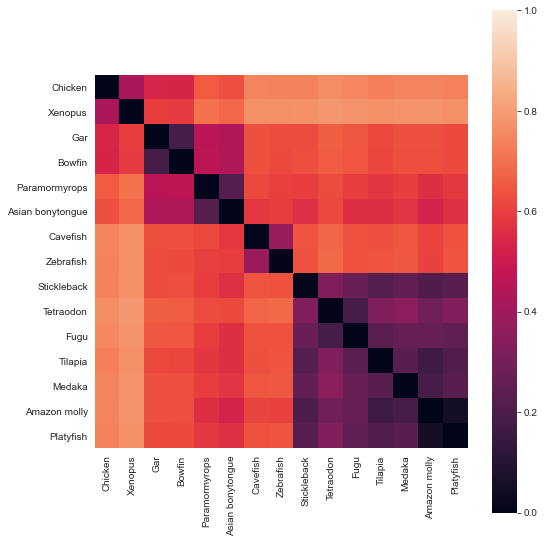

In [62]:
#Warning: computationally intensive cell.

if CORRECT_FOR_FRAC_BIAS:
    correct_frac_bias(adj_list, adj_list_rev)

make_distance_matrix(adj_list, adj_list_rev, SP_DICT, ALL_SPECIES)

### Neighbor-joining tree reconstruction <a name="neighbor-joining-tree-reconstruction"></a>

Use the `ape` R library to build a neighbor-joining tree from the distance matrix.

In [87]:
%%R 
library('ape')

nj_tree <- function(){
    dist_mat <- read.table('output/dist_mat', header = TRUE, sep = "", skip = 0)
    rownames(dist_mat) <- colnames(dist_mat)
    dist_mat <- as.matrix(dist_mat)

    a.nj <- bionj(dist_mat) # neighbour joining tree construction
    write.tree(a.nj, file='output/bionj.nwk', sep=''))
    tree <- root(a.nj, outgroup= c('Xenopus', 'Chicken'), resolve.root=TRUE) # root using the outgroups
    plot(tree, "phylo") # we plot it 
    nodelabels()
}

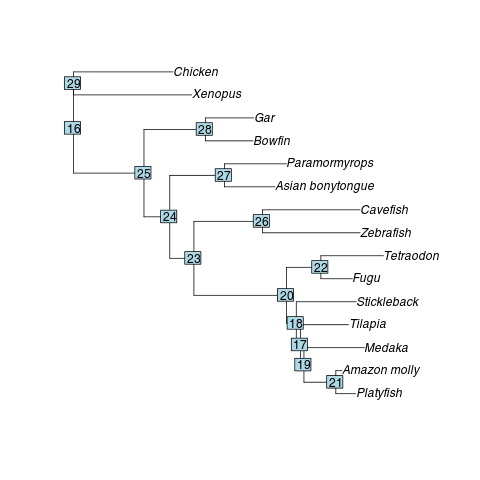

In [89]:
%%R
nj_tree()

### Bootstrap support  <a name="bootstrap-support"></a>

Generate 100 bootstrap replicates of the binary absence/presence adjacencie matrix.

In [99]:
bootstrap_matrix(all_adj, ALL_SPECIES)

10 bootstrap replicate done
20 bootstrap replicate done
30 bootstrap replicate done
40 bootstrap replicate done
50 bootstrap replicate done
60 bootstrap replicate done
70 bootstrap replicate done
80 bootstrap replicate done
90 bootstrap replicate done


In [103]:
%%R 
library('ape') 

boot_tree <- function(){
    dist_mat <- read.table('output/dist_mat', header = TRUE, sep = "", skip = 0)

    # bootstrap the adjacecncies
    for (i in 0:99){
      infile = paste('output/bootstrap_dist_mat_', as.character(i), '.txt', sep='')
      outfile = paste('output/bootstrap/bionj_', as.character(i), '.nwk', sep='')
      dist_mat <- read.table(infile, header = TRUE, sep = "", skip = 0)
      rownames(dist_mat) <- colnames(dist_mat)
      dist_mat <- as.matrix(dist_mat)
        
      # neighbour joining tree construction for each bootstrap replicate
      a.nj <- bionj(dist_mat)
      write.tree(a.nj, file=outfile)
    }
}

In [105]:
%%R
boot_tree()

R[write to console]: Error in scan(file = file, what = what, sep = sep, quote = quote, dec = dec,  : 
  line 1 did not have 30 elements




Error in scan(file = file, what = what, sep = sep, quote = quote, dec = dec,  : 
  line 1 did not have 30 elements


## Maximum parsimony gene order phylogeny <a name="gene-order-phylogeny-pars"></a>